In [3]:
from micrograd.engine import Value
import math
from micrograd.nn import *
import random
from graphviz import Digraph
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


ModuleNotFoundError: No module named 'engine'

In [2]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


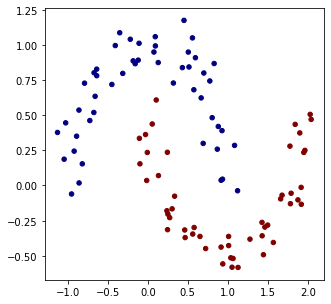

In [3]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [4]:
model =  Mehrkanoon_MLP(2,  nouts=[1], version=1)
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(3), LinearNeuron(

In [5]:
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)


Value(data=0.9520433262260188, grad=0) 0.64


In [6]:
# total_loss.backward()
# draw_dot(total_loss)

In [6]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.9520433262260188, accuracy 64.0%
step 1 loss 0.7949914872077816, accuracy 78.0%
step 2 loss 0.5411258398420274, accuracy 85.0%
step 3 loss 1.0187529920201865, accuracy 35.0%
step 4 loss 0.9751683576954211, accuracy 46.0%
step 5 loss 0.5911716041264776, accuracy 89.0%
step 6 loss 0.5614772511826422, accuracy 79.0%
step 7 loss 1.0434248456534607, accuracy 42.0%
step 8 loss 0.7945968075763185, accuracy 63.0%
step 9 loss 0.7555246701900671, accuracy 73.0%
step 10 loss 0.8297048796041655, accuracy 65.0%
step 11 loss 0.7012764570783102, accuracy 77.0%
step 12 loss 0.701789173596057, accuracy 77.0%
step 13 loss 0.7223545575986229, accuracy 71.0%
step 14 loss 0.516121126443189, accuracy 90.0%
step 15 loss 0.6044698673092264, accuracy 78.0%
step 16 loss 0.5556295696345459, accuracy 90.0%
step 17 loss 0.736192925851906, accuracy 78.0%
step 18 loss 0.6458596391573185, accuracy 68.0%
step 19 loss 0.6989658313096234, accuracy 70.0%
step 20 loss 0.7972613651059032, accuracy 69.0%
step 

(-1.5844860988872953, 2.1655139011127047)

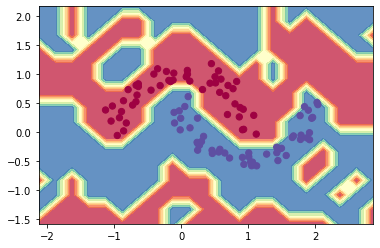

In [7]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

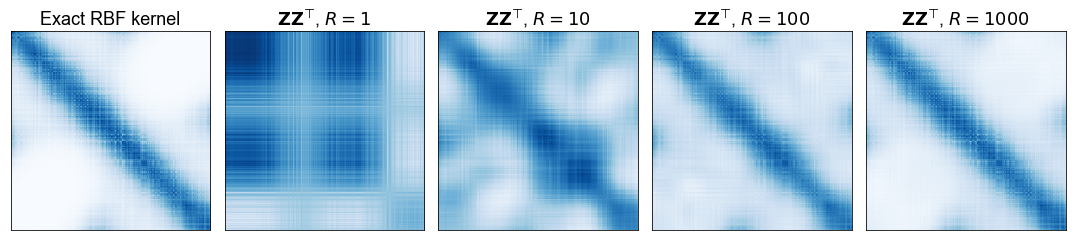

In [6]:
"""============================================================================
Kernel approximation using random Fourier features. Based on "Random Features
for Large-Scale Kernel Machines" by Rahimi and Recht (2007).
For more, see the accompanying blog post:
http://gregorygundersen.com/blog/2019/12/23/random-fourier-features/
============================================================================"""

import matplotlib.pyplot as plt
import numpy as np
from   sklearn.metrics.pairwise import rbf_kernel
from   sklearn.datasets import make_s_curve


# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 5)
fig.set_size_inches(15, 4)
font = {'fontname': 'arial', 'fontsize': 18}

N    = 1000
D    = 3
X, t = make_s_curve(N, noise=0.1)
X    = X[t.argsort()]
# The RBF kernel is the Gaussian kernel if we let \gamma = 1 / (2 \sigma^2).
K    = rbf_kernel(X, gamma=1/2.)

axes[0].imshow(K, cmap=plt.cm.Blues)
axes[0].set_title('Exact RBF kernel', **font)
axes[0].set_xticks([])
axes[0].set_yticks([])

for R, ax in zip([1, 10, 100, 1000, 5000], axes[1:]):
    W    = np.random.normal(loc=0, scale=1, size=(R, D))
    b    = np.random.uniform(0, 2*np.pi, size=R)
    B    = np.repeat(b[:, np.newaxis], N, axis=1)
    norm = 1./ np.sqrt(R)
    Z    = norm * np.sqrt(2) * np.cos(W @ X.T + B)
    ZZ   = Z.T@Z

    ax.imshow(ZZ, cmap=plt.cm.Blues)
    ax.set_title(r'$\mathbf{Z} \mathbf{Z}^{\top}$, $R=%s$' % R, **font)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

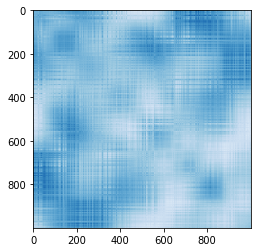

In [7]:
plt.imshow(K-ZZ, cmap=plt.cm.Blues)